# Pràctica 2: Neteja i anàlisi de dades

## 1. Dataset

El dataset emprat en aquesta pràctica és el generat a la PRA1 de l'assignatura, on vam recollir les dades de la web de Fotocasa dels pisos en lloguer a la ciutat de Barcelona (a data d'octubre de 2020), mitjançant scraping.

L'objectiu de l'anàlisi de les dades d'aquest dataset és respondre a les següents qüestions:

- Quines són les variables del dataset que influeixen de manera més significativa sobre el preu?
- Hi ha diferències significatives en els preus de lloguer entre els diferents barris de la ciutat?
- Hi ha diferències significatives en els preus de lloguer entre les diferents agències?
- Es pot crear un model de regressió que permeti predir el preu d'un habitatge en base a les seves característiques?

## 2. Selecció de dades

Primerament, determinarem quines són les variables del nostre dataset i el seu tipus. Seguidament, eliminarem aquelles que no aportin informació útil de cara a la nostra anàlisi. Finalment, farem una eliminació de files duplicades.

In [93]:
import pandas as pd

apartments = pd.read_csv('../csv/data_final.csv')

### Eliminació de dimensions

In [94]:
apartments.dtypes

id                       int64
address                 object
bathrooms                int64
building_subtype        object
building_type           object
conservation_state     float64
date                    object
discount                 int64
floor_elevator           int64
is_new_construction       bool
latitude               float64
link                    object
longitude              float64
price                  float64
realestate              object
realestate_id            int64
rooms                    int64
sqft_m2                  int64
neighbourhood           object
neighb_meanprice       float64
dtype: object

Donats els objectius de la nostra anàlisi, hi ha certes columnes del dataset que podem eliminar:

- __id__, que simplement conté l'índex de la fila dintre del dataset, de moment la deixem per si hem de sel·leccionar files per aquest índex.
- __address__, que conté la direcció del pis. Ja tenim el barri disponible a la columna __neighbourhood__ i per tant, aquest camp aporta informació innecessària a la nostra anàlisi.
- __date__, que conté la data en la que es va recollir la mostra. Solament la vam recollir un dia específic i per tant, no aporta cap informació rellevant a l'anàlisi actual.
- __realestate_id__, que conté l'identificador de l'agència que oferta el pis en lloguer. Ens preferim quedar amb el nom ja que ens permetrà visualitzar la informació de manera més clara

In [95]:
apartments = apartments.drop(columns=['address', 'date', 'realestate_id'])

### Eliminació de files duplicades

L'eliminació de files duplicades la portarem a terme en base a la variable __link__. Si tenim dues o més observacions del mateix pis de la web de Fotocasa, ens quedarem únicament amb la primera:

In [96]:
apartments.loc[apartments.duplicated('link')]

,id,bathrooms,building_subtype,building_type,conservation_state,discount,floor_elevator,is_new_construction,latitude,link,longitude,price,realestate,rooms,sqft_m2,neighbourhood,neighb_meanprice
39,39,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
40,40,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
41,41,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
42,42,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
43,43,1,Apartment,Flat,NaN,0,0,False,41.38071,/es/alquiler/vivienda/barcelona-capital/el-rav...,2.168707,525.0,INVERSIONES INMOBILIARIAS Y FINANCIERAS SANT A...,0,35,el raval,14.323614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11803,11803,2,Attic,Flat,1.0,200,1,False,41.39394,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.121359,3700.0,Stipek Ferrer Premium Properties,4,280,sarrià,16.866645
11804,11804,2,Attic,Flat,1.0,200,1,False,41.39394,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.121359,3700.0,Stipek Ferrer Premium Properties,4,280,sarrià,16.866645
12007,12007,5,Flat,Flat,2.0,0,1,False,41.39514,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.141838,5300.0,Max Ricart,6,280,sant gervasi - galvany,15.275452
12061,12061,2,Apartment,Flat,NaN,594,0,False,41.39498,/es/alquiler/vivienda/barcelona-capital/aire-a...,2.147670,6073.0,Homelike,4,100,sant gervasi - galvany,15.275452


In [97]:
apartments = apartments.drop_duplicates('link')

### Tipus de dades

Si observem els tipus de dades anteriors, es pot veure com __conservation_state__, __building_subtype__ y __building_type__ poden ser variables categòriques, o com __floor_elevator__ és en realitat una variable booleana. Podem aplicar la conversió sobre aquestes variables amb l'objectiu de millorar l'anàlisi:

In [98]:
apartments = apartments.astype({
    'conservation_state': 'category',
    'building_subtype': 'category',
    'building_type': 'category',
    'floor_elevator': 'bool',
    'neighbourhood':'category'
})

## 3. Neteja de dades

### Valors buits

Anem a determinar quins són els valors buits de cadascuna de les columnes:

In [99]:
apartments.isna().sum()

id                        0
bathrooms                 0
building_subtype          0
building_type             0
conservation_state     5340
discount                  0
floor_elevator            0
is_new_construction       0
latitude                  0
link                      0
longitude                 0
price                     4
realestate              106
rooms                     0
sqft_m2                   0
neighbourhood             1
neighb_meanprice          1
dtype: int64

Veiem que molts habitatges no tenen informació sobre l'estat de conservació. Omplirem amb -1 aquells que no en tinguin:

In [100]:
apartments['conservation_state'] = apartments['conservation_state'].cat.add_categories(-1)

apartments['conservation_state'] = apartments['conservation_state'].fillna(-1)

Donat que volem respondre a la pregunta de si hi ha diferències de preu entre les diferents agències, eliminem les observacions que no tenen agència:

In [101]:
apartments = apartments.dropna(subset=['realestate'])
apartments.isna().sum()

id                     0
bathrooms              0
building_subtype       0
building_type          0
conservation_state     0
discount               0
floor_elevator         0
is_new_construction    0
latitude               0
link                   0
longitude              0
price                  4
realestate             0
rooms                  0
sqft_m2                0
neighbourhood          1
neighb_meanprice       1
dtype: int64

Pel que fa al preu, es tracta de poques observacions que tenen un valor buit per aquesta variable. Com que l'objectiu d'aquesta anàlisi gira entorn al preu, decidim inserir la informació de forma manual consultant la web de Fotocasa:

In [102]:
apartments[apartments.price.isna()]['link']

12154    /es/alquiler/vivienda/barcelona-capital/calefa...
12155    /es/alquiler/vivienda/barcelona-capital/ascens...
12156    /es/alquiler/vivienda/barcelona-capital/aire-a...
12157    /es/alquiler/vivienda/barcelona-capital/aire-a...
Name: link, dtype: object

Les quatre observacions, un cop consultat el link al web de Fotocasa, corresponen a habitatges que no tenen preu, indicant-ho al web com pre "a consultar". Com necessitem treballar amb els preus, procedirem a eliminiar aquestes dades.

In [103]:
apartments = apartments.dropna(subset=['price'])

Finalment, ens queda omplir manualment les observacions que no tenen barri, de nou, mitjançant l'enllaç de Fotocasa per veure si podem determinar aquesta informació:

In [104]:
apartments[apartments.neighbourhood.isna()]

,id,bathrooms,building_subtype,building_type,conservation_state,discount,floor_elevator,is_new_construction,latitude,link,longitude,price,realestate,rooms,sqft_m2,neighbourhood,neighb_meanprice
1384,1384,1,Flat,Flat,-1.0,0,False,False,41.35395,/es/alquiler/vivienda/barcelona-capital/la-mar...,2.148532,750.0,FINCAS LAFONT,3,70,NaN,NaN


Veiem que es correspon amb el barri de "La marina de Port", així que li assignem el preu mitjà d'aquest barri.

In [105]:
mean_price_marina = float(apartments[apartments['neighbourhood']=='la marina de port'].head(1)['neighb_meanprice'])

apartments.loc[apartments.id ==1384, 'neighbourhood'] = 'la marina de port'
apartments.loc[apartments.id ==1384, 'neighb_meanprice'] = mean_price_marina



Podem observar que ara el dataset no té valors buits:

In [106]:
apartments.isna().sum()

id                     0
bathrooms              0
building_subtype       0
building_type          0
conservation_state     0
discount               0
floor_elevator         0
is_new_construction    0
latitude               0
link                   0
longitude              0
price                  0
realestate             0
rooms                  0
sqft_m2                0
neighbourhood          0
neighb_meanprice       0
dtype: int64

Podem eliminar l'id:

In [107]:
apartments = apartments.drop(columns=['id'])

### Outliers

El que primer farem, serà visualitzar a gràfics de tipus boxplot cadascuna de les variables quantitatives per tal de determinar si tenim o no outliers:

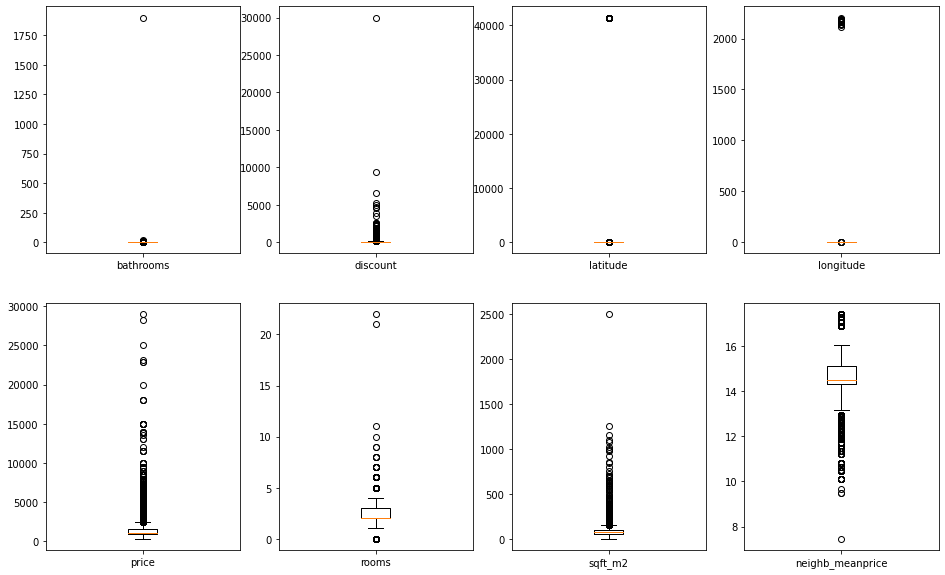

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import math

fig = plt.figure(figsize=(16,10))
numeric_attributes = apartments.select_dtypes(include=np.number).columns
for idx, column in enumerate(numeric_attributes):
    ax = fig.add_subplot(2, math.ceil(len(numeric_attributes)/2), idx+1)
    ax.boxplot(apartments[[column]], labels=[column])

Sembla evident que tenim prou valors extrems al dataset per a cadascuna de les variables quantitatives. El que cal és determinar si aquests valors són reals i per tant els hem de tenir en compte a l'anàlisi, o d'altra banda podem eliminar aquells que considerem outliers.

Si seleccionam els 5 preus més alts del dataset, podem comprovar com es tracta de valors vàlids quan accedim al detall a la pàgina de Fotocasa:

In [109]:
apartments.sort_values('price', ascending=False).head()[['link', 'rooms', 'bathrooms', 'realestate', 'sqft_m2', 'price']]

,link,rooms,bathrooms,realestate,sqft_m2,price
12153,/es/alquiler/vivienda/barcelona-capital/aire-a...,4,4,VIP PISOS,600,29000.0
12152,/es/alquiler/vivienda/barcelona-capital/aire-a...,8,7,Homelike,550,28279.0
12151,/es/alquiler/vivienda/barcelona-capital/aire-a...,21,21,ENGEL & VOELKERS,2500,25000.0
12150,/es/alquiler/vivienda/barcelona-capital/aire-a...,3,2,Homelike,85,23092.0
12149,/es/alquiler/vivienda/barcelona-capital/aire-a...,2,1,Homelike,54,22839.0


Sembla per tant que existeixen uns pocs pisos al dataset amb preus molt elevants, i característiques com nombre d'habitacions, metres quadrats o nombre de banys amb valors que tot i semblar extrems, són vàlids. Per aquest motiu, decidim __mantenir__ aquestes observacions per tal de dur a terme l'anàlisi de dades.

D'altra banda, sí que hem d'examinar la variable latitude i longitude, hi veiem valors sospitosos. Esperem que tots els habitages es trobin a la ciutat de Barcelona, per tant, que tinguin coordenades molt semblants.